In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import (cross_val_score, train_test_split,
                                    GridSearchCV, RandomizedSearchCV)
from sklearn.preprocessing import Imputer

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the data.

In [2]:
train = pd.read_csv('data/train_final.csv')
test = pd.read_csv('data/test_final.csv')

In [3]:
train.head(5)

,id,Y,F1,F2,F3,F4,F5,F6,F7,F8,...,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27
0,1,0,1,0,0.107576,0,0.0,1,1,1,...,104,22902.0,1,0,18,0.042295,1,0,27,0.028250
1,2,0,1,0,0.142357,0,0.0,7,1,1,...,144,11400.0,1,0,8,0.021417,1,0,67,0.253574
2,3,0,1,0,0.492318,0,3.0,4205,1,1,...,112,4833.0,1,0,13,0.502212,1,1,35,0.373397
3,4,0,1,0,-0.053028,0,2.0,2,1,1,...,127,3250.0,1,1,8,0.000000,1,0,50,0.674254
4,5,0,1,0,0.730797,0,0.0,11,1,1,...,148,4000.0,1,1,5,0.787592,1,0,71,0.371157


In [4]:
test.head(5)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27
0,49999,1,0,0.460297,0,0.0,1,1,1,1,...,127,5016.0,1,0,8,0.405964,1,2,50,0.943392
1,50000,1,0,0.112573,0,3.0,2,1,1,1,...,137,8300.0,1,5,5,0.100761,1,0,60,0.161306
2,50001,1,0,0.061461,1,0.0,29,1,1,3,...,142,NaN,1,5,4,0.063096,1,0,65,705.000000
3,50002,1,0,0.523372,0,0.0,1,1,1,1,...,160,2500.0,1,1,7,0.534274,1,0,83,0.358657
4,50003,1,0,0.586772,0,2.0,44188,1,1,7,...,106,7472.0,1,4,12,0.759767,1,0,29,0.244748


In [5]:
# Drop ID column now, we don't really need it.

train = train.drop(['id'], axis=1)
test = test.drop(['id'], axis=1)

# Feature/Data Exploration
## Let's explore the features and data to get a feel for them.

In [6]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Unique values of each feature in train/test set")
train_feat_counts = train.apply(lambda x: len(x.unique()))
test_feat_counts = test.apply(lambda x: len(x.unique()))
feat_counts = pd.concat([train_feat_counts, test_feat_counts], axis=1)
print(feat_counts)

Train shape: (49998, 28)
Test shape: (50000, 27)
Unique values of each feature in train/test set
         0        1
F1       9     11.0
F10     23     23.0
F11     43     42.0
F12      9     10.0
F13     10      8.0
F14     16     14.0
F15     10      8.0
F16    310    307.0
F17      9      9.0
F18     83     83.0
F19   8771   8802.0
F2      12     11.0
F20     10     10.0
F21    334    295.0
F22     55     50.0
F23  42562  42460.0
F24      9     11.0
F25     14     13.0
F26     83     83.0
F27  41705  41563.0
F3   49998  49998.0
F4       9     11.0
F5      12     12.0
F6    1880   1880.0
F7       9     11.0
F8       9     11.0
F9     322    312.0
Y        2      NaN


In [7]:
train.head(1).ix[:, :20]

,Y,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19
0,0,1,0,0.107576,0,0.0,1,1,1,1,0,32,1,1,0,1,1.77,1,104,22902.0


In [8]:
train.head(1).ix[:, 20:]

,F20,F21,F22,F23,F24,F25,F26,F27
0,1,0,18,0.042295,1,0,27,0.02825


## Let's try to narrow down the categorical variables. Some may be ordinal, some may be nominal (and thus require one-hot encoding). Categorical variables will most certainly have less than 49998 (number of examples in training set) categories.

Possible Categorical variables: Number of unique values
- F1: 9
- F2: 12
- F4: 9
- F6: 1880
- F7: 9
- F8: 9
- F9: 322
- F10: 23
- F11: 43
- F12: 9
- F13: 10
- F14: 16
- F15: 10
- F17: 9
- F18: 83
- F20: 10
- F21: 334
- F22: 55
- F24: 9
- F25: 14
- F26: 83

### Let's try to print variables with < 100 unique values first.

In [9]:
# Possible categorical features - all of these have < 100 unique values.
cat_feats = train_feat_counts[train_feat_counts < 100]
print(cat_feats)

Y       2
F1      9
F2     12
F4      9
F5     12
F7      9
F8      9
F10    23
F11    43
F12     9
F13    10
F14    16
F15    10
F17     9
F18    83
F20    10
F22    55
F24     9
F25    14
F26    83
dtype: int64


In [10]:
def print_unique_values(df, feat):
    """Given a dataframe and feature name, 
       display all unique values of a particular feature. """
    print('{}: {}'.format(feat, sorted(df.ix[:, feat].unique())))

for feat in cat_feats.index:
    print_unique_values(train, feat)

Y: [0, 1]
F1: [1, 2, 3, 4, 5, 6, 8, 12, 18]
F2: [0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 96, 98]
F4: [0, 1, 2, 3, 4, 5, 6, 7, 8]
F5: [0.0, 1.0, 2.0, 3.0, 5.0, nan, 4.0, 6.0, 7.0, 8.0, 9.0, 10.0]
F7: [1, 2, 3, 4, 5, 6, 8, 10, 23]
F8: [1, 2, 3, 4, 5, 6, 7, 8, 9]
F10: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 23, 29, 54]
F11: [18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 63]
F12: [1, 2, 3, 4, 5, 6, 7, 11, 12]
F13: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
F14: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 96, 98]
F15: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
F17: [1, 2, 3, 4, 5, 6, 7, 8, 10]
F18: [98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 

 ### F5 is probably not a categorical feature, since its a floating-point value. The rest of the features are rather inconclusive.

## Let's look for any correlated features.

In [11]:
train_corr = train.corr()
train_corr[train_corr > 0.2]

,Y,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27
Y,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F2,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.986766,NaN,NaN
F3,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
F4,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F5,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F6,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
train_corr[train_corr < -0.2]

,Y,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27
Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.210803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.210803,NaN
F6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Looks like F2, F14, and F25 are highly correlated. Is this also the case in the test dataset?

In [13]:
test_corr = test.corr()
test_corr[test_corr > 0.2]

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27
F1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F2,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.987521,NaN,NaN
F3,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
F4,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F5,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F6,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F7,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,NaN,0.217611,NaN,NaN,0.437405,NaN,NaN,NaN,NaN,NaN


In [14]:
test_corr[test_corr < - 0.2]

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27
F1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.211963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.211963,NaN
F6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Out of the 3 features, F14 probably retains the most information, seeing how it has 16 unique values that appear in the dataframe, which is more than either F2 or F25. Let's drop both of those features.

In [15]:
### Try not dropping features, see whether or not pipeline improves.

# train = train.drop(['F2', 'F25'], axis=1)
# test = test.drop(['F2', 'F25'], axis=1)

## Are there any missing values? Missing values could break any models we'd like to train on.

In [16]:
print(pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1))

        0       1
F1      0     0.0
F10     0     0.0
F11     0     0.0
F12     0     0.0
F13     0     0.0
F14     0     0.0
F15     0     0.0
F16     0     0.0
F17     0     0.0
F18     0     0.0
F19  9828  9984.0
F2      0     0.0
F20     0     0.0
F21     0     0.0
F22     0     0.0
F23     0     0.0
F24     0     0.0
F25     0     0.0
F26     0     0.0
F27     0     0.0
F3      0     0.0
F4      0     0.0
F5   1268  1353.0
F6      0     0.0
F7      0     0.0
F8      0     0.0
F9      0     0.0
Y       0     NaN


In [17]:
print_unique_values(train, 'F5')

F5: [0.0, 1.0, 2.0, 3.0, 5.0, nan, 4.0, 6.0, 7.0, 8.0, 9.0, 10.0]


### How we're handling missing values:
We have a good number of missing values in F5 and F19. Looks like we'll need to impute them. Since F5 looks like an ordinal categorical feature, its probably safer to impute via the median. F19 looks like a continuous feature, so it's safe to just take the mean of the column. We may want to discard F19 later, since it could lead to issues down the line.

Further resources for imputation:
- [Impute categorical missing values in scikit-learn](https://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn)
- [Imputation of missing values for categories in pandas](https://stackoverflow.com/questions/32617811/imputation-of-missing-values-for-categories-in-pandas)

F5's mean: 0.7534783500923455, median:0.0
0.0     29110
1.0      8682
2.0      6516
3.0      3129
4.0       977
5.0       232
6.0        55
7.0        18
8.0         8
9.0         2
10.0        1
Name: F5, dtype: int64


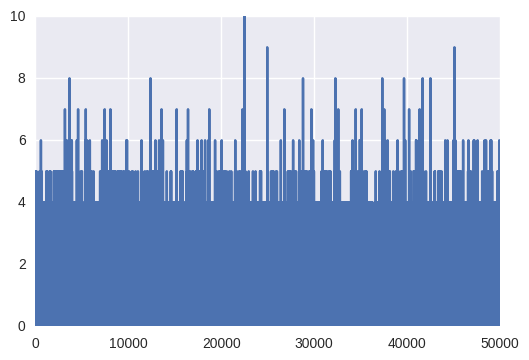

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, ax = plt.subplots()
ax.plot(train.ix[:, 'F5'])
feat5 = train.ix[:, 'F5']
print('F5\'s mean: {}, median:{}'.format(feat5.mean(), feat5.median()))
print(feat5.value_counts())

F19's mean: 6665.120064724919, median:5362.0
5000.0     908
4000.0     704
6000.0     669
3000.0     608
0.0        557
2500.0     525
10000.0    493
3500.0     476
7000.0     408
4500.0     396
8000.0     356
2000.0     349
7500.0     341
10500.0    324
5500.0     318
6500.0     277
9000.0     256
1.0        212
3600.0     203
4200.0     198
6250.0     193
8333.0     191
12000.0    190
3750.0     190
3200.0     183
1500.0     180
4166.0     176
3333.0     175
12500.0    172
2800.0     170
          ... 
74872.0      1
8569.0       1
34920.0      1
10078.0      1
10832.0      1
10925.0      1
14383.0      1
5915.0       1
1634.0       1
82000.0      1
17860.0      1
2537.0       1
1387.0       1
4744.0       1
9772.0       1
58000.0      1
9172.0       1
1460.0       1
12444.0      1
14854.0      1
10615.0      1
1107.0       1
5856.0       1
13425.0      1
6005.0       1
12387.0      1
3831.0       1
8784.0       1
4024.0       1
7687.0       1
Name: F19, dtype: int64


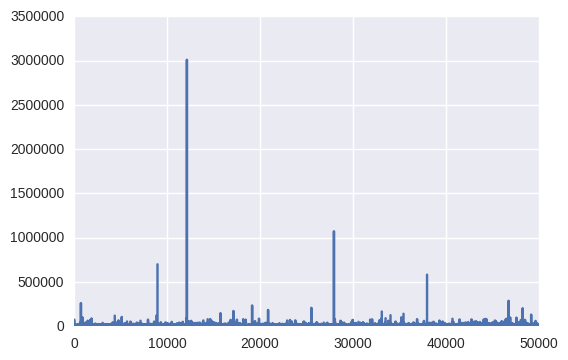

In [19]:
fig, ax = plt.subplots()
feat19 = train.ix[:, 'F19']
ax.plot(feat19)
print('F19\'s mean: {}, median:{}'.format(feat19.mean(), feat19.median()))
print(feat19.value_counts())

In [20]:
# Drop necessary labels before imputation.
y = train.Y
X = train.drop(["Y"], axis=1)
X_test = test

In [21]:
from sklearn.preprocessing import Imputer

# train = train.apply(lambda x: x.fillna(x.value_counts().index[0]))
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
train_xform = imp.fit_transform(X)
# TODO: Impute dataframe so that F5 uses median
# and F19 uses mean. For now, we'll impute via mean for both.

X = pd.DataFrame(train_xform, columns=X.columns)
test_xform = imp.transform(X_test)
X_test = pd.DataFrame(test_xform, columns=X_test.columns)

X.head(5)

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27
0,1.0,0.0,0.107576,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,104.0,22902.0,1.0,0.0,18.0,0.042295,1.0,0.0,27.0,0.028250
1,1.0,0.0,0.142357,0.0,0.0,7.0,1.0,1.0,1.0,1.0,...,144.0,11400.0,1.0,0.0,8.0,0.021417,1.0,0.0,67.0,0.253574
2,1.0,0.0,0.492318,0.0,3.0,4205.0,1.0,1.0,3.0,1.0,...,112.0,4833.0,1.0,0.0,13.0,0.502212,1.0,1.0,35.0,0.373397
3,1.0,0.0,-0.053028,0.0,2.0,2.0,1.0,1.0,5.0,2.0,...,127.0,3250.0,1.0,1.0,8.0,0.000000,1.0,0.0,50.0,0.674254
4,1.0,0.0,0.730797,0.0,0.0,11.0,1.0,1.0,1.0,1.0,...,148.0,4000.0,1.0,1.0,5.0,0.787592,1.0,0.0,71.0,0.371157


In [22]:
X_test.head(5)

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27
0,1.0,0.0,0.460297,0.0,0.0,1.0,1.0,1.0,1.0,3.0,...,127.0,5016.000000,1.0,0.0,8.0,0.405964,1.0,2.0,50.0,0.943392
1,1.0,0.0,0.112573,0.0,3.0,2.0,1.0,1.0,1.0,1.0,...,137.0,8300.000000,1.0,5.0,5.0,0.100761,1.0,0.0,60.0,0.161306
2,1.0,0.0,0.061461,1.0,0.0,29.0,1.0,1.0,3.0,1.0,...,142.0,6665.120065,1.0,5.0,4.0,0.063096,1.0,0.0,65.0,705.000000
3,1.0,0.0,0.523372,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,160.0,2500.000000,1.0,1.0,7.0,0.534274,1.0,0.0,83.0,0.358657
4,1.0,0.0,0.586772,0.0,2.0,44188.0,1.0,1.0,7.0,1.0,...,106.0,7472.000000,1.0,4.0,12.0,0.759767,1.0,0.0,29.0,0.244748


## Let's get down to business and start building models!

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=42)

In [56]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
              'n_estimators': [120, 300, 500, 800, 1200],
              'max_features': ['sqrt', 'log2', None], 
              'max_depth': [None, 5, 8, 15, 25], 
              'min_samples_split': [2, 5, 10, 15, 100], 
              'min_samples_leaf':[1, 2, 5, 10], 
             }

clf = RandomizedSearchCV(RandomForestClassifier(), param_grid, n_iter=30, cv=10, scoring='roc_auc', n_jobs=-1)
clf.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=30, n_jobs=-1,
          param_distributions={'max_depth': [None, 5, 8, 15, 25], 'n_estimators': [120, 300, 500, 800, 1200], 'min_samples_split': [2, 5, 10, 15, 100], 'max_features': ['sqrt', 'log2', None], 'min_samples_leaf': [1, 2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=0)

In [58]:
print("Best parameter set found on development set with cv={}:\n"
      .format(10))
print(clf.best_params_)
print("Best holdout score found on development set with cv={}:\n"
      .format(10))
print(clf.best_score_)
print()
score = clf.score(X_val, y_val)
# print("Test score for these parameters: {}".format(score))
# for params, mean_score, scores in clf.grid_scores_:
#     print("{0:.3f} (+/-{1:.03f}) for {2}".format(
#           mean_score, scores.std() * 2, params))

Best parameter set found on development set with cv=10:

{'min_samples_leaf': 10, 'n_estimators': 500, 'max_features': 'sqrt', 'min_samples_split': 15, 'max_depth': 8}
Best holdout score found on development set with cv=10:

0.859748413386



In [59]:
print(clf.cv_results_['mean_train_score'])
print(clf.cv_results_['mean_test_score'])
print(score)

[ 0.86473373  0.95928276  0.95183945  0.923868    0.8908181   0.96333435
  0.88413278  0.94328041  0.91384638  0.88777455  0.99205791  0.93592429
  0.95592948  0.9825018   0.96133698  0.86449871  0.99074495  0.88724079
  0.8845861   0.86125324  0.86459293  0.88533655  0.86441594  0.98213464
  0.99993941  0.97622046  0.94303856  0.95503566  0.97157248  0.86008199]
[ 0.85502309  0.85790791  0.85363026  0.85903901  0.85875259  0.85376526
  0.85924699  0.85894807  0.85960304  0.8586607   0.85098529  0.85780587
  0.85345011  0.85539866  0.85620105  0.85504218  0.84361216  0.85914986
  0.85804865  0.85448195  0.8546846   0.85974841  0.85494374  0.85390707
  0.83281743  0.85671466  0.85930093  0.85893367  0.84872776  0.85273896]
0.85420814445


In [27]:
predictions = clf.predict_proba(X_test)[:, 0]

In [28]:
def write_results(outfile, predictions):
    ID = range(49999, 99998 + 1)
    with open(outfile, 'w') as f:
        f.write('id,Y\n')
        for instance, prediction in zip(ID, predictions):
            f.write('{},{}\n'.format(instance, prediction))

In [29]:
outfile = 'output/rf_depth15_estimators300_featureslog2_split2_leaf10.csv'
write_results(outfile, predictions)

## Let's explore the hyperparameters some more.

In [29]:
clf.cv_results_['params']

({'max_depth': None,
  'max_features': None,
  'min_samples_leaf': 1,
  'min_samples_split': 100,
  'n_estimators': 500},
 {'max_depth': 5,
  'max_features': 'log2',
  'min_samples_leaf': 5,
  'min_samples_split': 100,
  'n_estimators': 120},
 {'max_depth': 5,
  'max_features': 'log2',
  'min_samples_leaf': 2,
  'min_samples_split': 15,
  'n_estimators': 800},
 {'max_depth': None,
  'max_features': None,
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 300},
 {'max_depth': 5,
  'max_features': 'log2',
  'min_samples_leaf': 10,
  'min_samples_split': 100,
  'n_estimators': 120},
 {'max_depth': 15,
  'max_features': 'sqrt',
  'min_samples_leaf': 10,
  'min_samples_split': 2,
  'n_estimators': 300},
 {'max_depth': 5,
  'max_features': None,
  'min_samples_leaf': 2,
  'min_samples_split': 2,
  'n_estimators': 1200},
 {'max_depth': 5,
  'max_features': 'log2',
  'min_samples_leaf': 2,
  'min_samples_split': 2,
  'n_estimators': 300},
 {'max_depth': 15,
  'max_features': 

In [37]:
feat_importances = clf.best_estimator_.feature_importances_
zipped_importances = zip(X.columns, feat_importances)
sorted(zipped_importances, key=lambda x: x[1], reverse=True)

[('F23', 0.11948052),
 ('F27', 0.1140123),
 ('F3', 0.10102529),
 ('F18', 0.098974712),
 ('F19', 0.08475735),
 ('F22', 0.073957622),
 ('F25', 0.07272727),
 ('F2', 0.067805879),
 ('F14', 0.043198906),
 ('F10', 0.041285031),
 ('F11', 0.035133287),
 ('F6', 0.032672592),
 ('F5', 0.030758714),
 ('F16', 0.024606971),
 ('F9', 0.02378674),
 ('F21', 0.017634997),
 ('F26', 0.013943951),
 ('F1', 0.0010936433),
 ('F20', 0.00095693779),
 ('F4', 0.00082023238),
 ('F12', 0.00054682163),
 ('F17', 0.00054682163),
 ('F7', 0.00027341081),
 ('F8', 0.0),
 ('F13', 0.0),
 ('F15', 0.0),
 ('F24', 0.0)]

In [32]:
import xgboost as xgb



param_grid = {
              'learning_rate': [0.01, 0.025, 0.05, 0.1],
              'gamma': [0.1, 0.3, 0.5, 0.7, 0.9], 
              'max_depth': [3, 7, 12, 17, 25], 
              'min_child_weight': [1, 3, 5, 7],
              'subsample': [0.6, 0.8, 1.0], 
              'colsample_bytree': [0.6, 0.8, 1.0], 
              'reg_lambda': [0.01, 0.1, 1.0],
              'reg_alpha': [0, 0.1, 0.5, 1.0],
             }

clf = RandomizedSearchCV(xgb.XGBClassifier(), param_grid, cv=10, scoring='roc_auc', n_jobs=6)
clf.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
          fit_params={}, iid=True, n_iter=10, n_jobs=6,
          param_distributions={'max_depth': [3, 7, 12, 17, 25], 'reg_lambda': [0.01, 0.1, 1.0], 'reg_alpha': [0, 0.1, 0.5, 1.0], 'min_child_weight': [1, 3, 5, 7], 'colsample_bytree': [0.6, 0.8, 1.0], 'learning_rate': [0.01, 0.025, 0.05, 0.1], 'gamma': [0.1, 0.3, 0.5, 0.7, 0.9], 'subsample': [0.6, 0.8, 1.0]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=0)

In [33]:
print("Best parameter set found on development set with cv={}:\n"
      .format(10))
print(clf.best_params_)
print("Best holdout score found on development set with cv={}:\n"
      .format(10))
print(clf.best_score_)
print()
score = clf.score(X_val, y_val)

print(clf.cv_results_['mean_train_score'])
print(clf.cv_results_['mean_test_score'])
print(score)

Best parameter set found on development set with cv=10:

{'min_child_weight': 7, 'gamma': 0.5, 'reg_alpha': 0.5, 'max_depth': 7, 'colsample_bytree': 0.8, 'learning_rate': 0.01, 'reg_lambda': 0.1, 'subsample': 1.0}
Best holdout score found on development set with cv=10:

0.858686706849

[ 0.97596245  0.91785885  0.96575021  0.95216593  0.96235367  0.99999977
  0.87802163  0.8585545   0.92305593  0.85858715]
[ 0.84243356  0.85676173  0.85045427  0.85164255  0.85422049  0.83496424
  0.85868671  0.85556953  0.85562792  0.85587362]
0.851234825513


In [34]:
outfile = 'output/xgb_lambda0.1_alpha0.5_subsample1.0_gamma0.9_lr0.01_colsample0.8_minchildw7_maxdepth7.csv'
predictions = clf.predict_proba(X_test)[:, 0]
write_results(outfile, predictions)

In [ ]:
# from sklearn.ensemble import ExtraTreesClassifier

# param_grid = {
#               'n_estimators': [120, 300, 500, 800, 1200],
#               'max_features': ['sqrt', 'log2', None], 
#               'max_depth': [5, 8, 15, 25], 
#               'min_samples_split': [2, 5, 10, 15, 100], 
#               'min_samples_leaf':[1, 2, 5, 10], 
#              }

# clf = RandomizedSearchCV(RandomForestClassifier(), param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
# clf.fit(X_train, y_train)

In [54]:
# print(clf.predict_proba(X_val)[4950:, :])
# print(y_val)